In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random
import tensorflow as tf
import time
import warnings
warnings.filterwarnings('ignore')

# Set style untuk plot yang lebih menarik
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 Libraries loaded successfully!")


📚 Libraries loaded successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Load dan preprocess data
print("📊 Loading data...")

# Sesuaikan path dengan lokasi data Anda
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/aa_442100118673_engineered.csv')
# df
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
# df.drop('READ_DATE_day', axis=1, inplace=True)
df

# Remove outliers (IQR method)
Q1_without_kwh = df.quantile(0.25)
Q3_without_kwh = df.quantile(0.75)
IQR_without_kwh = Q3_without_kwh - Q1_without_kwh
outlier_without_kwh = (df < (Q1_without_kwh - 1.5 * IQR_without_kwh)) | (df > (Q3_without_kwh + 1.5 * IQR_without_kwh))
rows_to_keep = df[~outlier_without_kwh.any(axis=1)].index
df = df.loc[rows_to_keep]

# Apply HP filter untuk decomposition
lambda_daily_365 = 1600 * (365 / 4) ** 4
cycle, trend = hpfilter(df['KWH_EXP'], lamb=lambda_daily_365)
df['trend'] = trend
df['cycle'] = cycle

df.set_index('READ_DATE', inplace=True)
df.drop(['KWH_EXP_MA', 'KWH_EXP_ES', 'trend_ma', 'cycle_ma'], axis=1, inplace=True, errors='ignore')

print(f"✅ Data loaded: {df.shape}")
print(f"📅 Date range: {df.index.min()} to {df.index.max()}")
print(f"🎯 Target: KWH_EXP")


📊 Loading data...
✅ Data loaded: (1314, 13)
📅 Date range: 2019-01-06 00:00:00 to 2024-05-31 00:00:00
🎯 Target: KWH_EXP


In [4]:
# Helper functions
def create_dataset(X, y, time_steps=1):
    """Create dataset dengan timesteps untuk LSTM"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

def train_model_and_get_predictions(X_train, y_train, X_test, y_test, timesteps,
                                   model_type='bilstm', best_features=None,
                                   target_scaler=None, verbose=0):
    """
    Train model dan return predictions dengan metrics
    """
    # Feature selection jika menggunakan GA
    if best_features is not None:
        selected_features = [i for i in range(len(best_features)) if best_features[i] == 1]
        X_train_selected = X_train[:, selected_features]
        X_test_selected = X_test[:, selected_features]
    else:
        X_train_selected = X_train
        X_test_selected = X_test

    # Create sequences
    X_train_t, y_train_t = create_dataset(X_train_selected, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test_selected, y_test, timesteps)

    # Build model
    if model_type == 'bilstm':
        model = Sequential([
            Input(shape=(timesteps, X_train_selected.shape[1])),
            Bidirectional(LSTM(128, return_sequences=True)),
            Bidirectional(LSTM(64)),
            Dense(1)
        ])
    else:  # lstm
        model = Sequential([
            Input(shape=(timesteps, X_train_selected.shape[1])),
            LSTM(128, return_sequences=True),
            LSTM(64),
            Dense(1)
        ])

    model.compile(optimizer='adam', loss='mse')

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, verbose=0)

    # Train
    model.fit(X_train_t, y_train_t, validation_split=0.1, epochs=50,
              batch_size=512, callbacks=[early_stopping, reduce_lr], verbose=verbose)

    # Predict
    y_pred = model.predict(X_test_t, verbose=0)

    # Inverse transform
    if target_scaler:
        y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1)).flatten()
        y_pred_orig = target_scaler.inverse_transform(y_pred).flatten()
    else:
        y_test_orig = y_test_t
        y_pred_orig = y_pred.flatten()

    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_test_orig, y_pred_orig),
        'MAE': mean_absolute_error(y_test_orig, y_pred_orig),
        'R2': r2_score(y_test_orig, y_pred_orig),
        'MAPE': mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    }

    return y_pred_orig, y_test_orig, metrics

print("🔧 Helper functions defined!")


🔧 Helper functions defined!


In [5]:
# Genetic Algorithm functions (simplified version)
def evaluate_chromosome_simple(chromosome, X_train, y_train, timesteps, model_type='bilstm'):
    """Simplified GA evaluation function"""
    selected_features = [i for i in range(len(chromosome)) if chromosome[i] == 1]
    if len(selected_features) == 0:  # Avoid empty selection
        return float('inf')

    X_train_selected = X_train[:, selected_features]
    X_train_t, y_train_t = create_dataset(X_train_selected, y_train, timesteps)

    if model_type == 'bilstm':
        model = Sequential([
            Input(shape=(timesteps, len(selected_features))),
            Bidirectional(LSTM(64, return_sequences=True)),
            Bidirectional(LSTM(32)),
            Dense(1)
        ])
    else:
        model = Sequential([
            Input(shape=(timesteps, len(selected_features))),
            LSTM(64, return_sequences=True),
            LSTM(32),
            Dense(1)
        ])

    model.compile(optimizer='adam', loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0)

    model.fit(X_train_t, y_train_t, epochs=10, validation_split=0.1,
              callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_train_t, verbose=0)
    mse = mean_squared_error(y_train_t, y_pred)

    return mse

def simple_genetic_algorithm(X_train, y_train, timesteps, model_type='bilstm',
                           pop_size=8, num_generations=3, mutation_rate=0.1):
    """Simplified GA for feature selection"""
    print(f"🧬 Running simplified GA for {model_type} with timesteps={timesteps}")

    num_features = X_train.shape[1]

    # Initialize population
    population = [np.random.randint(2, size=num_features) for _ in range(pop_size-1)]
    population.append(np.ones(num_features, dtype=int))  # All features

    best_chromosome = None
    best_fitness = float('inf')

    for generation in range(num_generations):
        fitnesses = []
        for chromosome in population:
            fitness = evaluate_chromosome_simple(chromosome, X_train, y_train, timesteps, model_type)
            fitnesses.append(fitness)

            if fitness < best_fitness:
                best_fitness = fitness
                best_chromosome = chromosome.copy()

        # Selection (top 50%)
        indices = np.argsort(fitnesses)[:pop_size//2]
        parents = [population[i] for i in indices]

        # Crossover and mutation
        offspring = []
        for _ in range(pop_size - len(parents)):
            parent1, parent2 = random.sample(parents, 2)
            crossover_point = random.randint(1, len(parent1)-1)
            child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))

            # Mutation
            if random.random() < mutation_rate:
                mutation_point = random.randint(0, len(child)-1)
                child[mutation_point] = 1 - child[mutation_point]

            offspring.append(child)

        population = parents + offspring
        print(f"  Generation {generation+1}: Best fitness = {best_fitness:.4f}")

    return best_chromosome

print("🧬 GA functions defined!")


🧬 GA functions defined!


In [6]:
def compare_all_models_single_timestep(timestep=3, use_ga=True):
    """
    Compare all models for a single timestep
    """
    print(f"\n{'='*80}")
    print(f"🔍 ANALYZING TIMESTEP = {timestep}")
    print(f"{'='*80}")

    # Split data
    train = df.loc['2019-01-01':'2022-12-31']
    test = df.loc['2023-01-01':'2024-05-24']

    # Data dengan HP filter (menggunakan trend dan cycle)
    train_hp = train.copy()
    test_hp = test.copy()

    # Data tanpa HP filter
    train_no_hp = train.drop(['trend', 'cycle'], axis=1, errors='ignore')
    test_no_hp = test.drop(['trend', 'cycle'], axis=1, errors='ignore')

    # Scaling untuk data dengan HP
    scaler_features_hp = StandardScaler()
    scaler_target_hp = StandardScaler()

    X_train_hp = scaler_features_hp.fit_transform(train_hp)
    y_train_hp = scaler_target_hp.fit_transform(train_hp[['KWH_EXP']]).ravel()
    X_test_hp = scaler_features_hp.transform(test_hp)
    y_test_hp = scaler_target_hp.transform(test_hp[['KWH_EXP']]).ravel()

    # Scaling untuk data tanpa HP
    scaler_features_no_hp = StandardScaler()
    scaler_target_no_hp = StandardScaler()

    X_train_no_hp = scaler_features_no_hp.fit_transform(train_no_hp)
    y_train_no_hp = scaler_target_no_hp.fit_transform(train_no_hp[['KWH_EXP']]).ravel()
    X_test_no_hp = scaler_features_no_hp.transform(test_no_hp)
    y_test_no_hp = scaler_target_no_hp.transform(test_no_hp[['KWH_EXP']]).ravel()

    # Get best features from GA (if enabled)
    best_features_bilstm_hp = None
    best_features_bilstm_no_hp = None
    best_features_lstm_hp = None
    best_features_lstm_no_hp = None

    if use_ga:
        print("\n🧬 Running Genetic Algorithm for feature selection...")
        best_features_bilstm_hp = simple_genetic_algorithm(X_train_hp, y_train_hp, timestep, 'bilstm')
        best_features_bilstm_no_hp = simple_genetic_algorithm(X_train_no_hp, y_train_no_hp, timestep, 'bilstm')
        best_features_lstm_hp = simple_genetic_algorithm(X_train_hp, y_train_hp, timestep, 'lstm')
        best_features_lstm_no_hp = simple_genetic_algorithm(X_train_no_hp, y_train_no_hp, timestep, 'lstm')
        print("✅ GA completed!")

    results = {}

    print("\n🚀 Training models...")

    # BiLSTM Models
    if use_ga:
        # GA + HP + BiLSTM
        pred, actual, metrics = train_model_and_get_predictions(
            X_train_hp, y_train_hp, X_test_hp, y_test_hp, timestep, 'bilstm',
            best_features_bilstm_hp, scaler_target_hp
        )
        results['GA + HP + BiLSTM'] = {'pred': pred, 'actual': actual, 'metrics': metrics}
        print(f"  ✓ GA + HP + BiLSTM: R² = {metrics['R2']:.4f}")

        # GA + BiLSTM
        pred, actual, metrics = train_model_and_get_predictions(
            X_train_no_hp, y_train_no_hp, X_test_no_hp, y_test_no_hp, timestep, 'bilstm',
            best_features_bilstm_no_hp, scaler_target_no_hp
        )
        results['GA + BiLSTM'] = {'pred': pred, 'actual': actual, 'metrics': metrics}
        print(f"  ✓ GA + BiLSTM: R² = {metrics['R2']:.4f}")

    # HP + BiLSTM
    pred, actual, metrics = train_model_and_get_predictions(
        X_train_hp, y_train_hp, X_test_hp, y_test_hp, timestep, 'bilstm',
        None, scaler_target_hp
    )
    results['HP + BiLSTM'] = {'pred': pred, 'actual': actual, 'metrics': metrics}
    print(f"  ✓ HP + BiLSTM: R² = {metrics['R2']:.4f}")

    # BiLSTM (Baseline)
    pred, actual, metrics = train_model_and_get_predictions(
        X_train_no_hp, y_train_no_hp, X_test_no_hp, y_test_no_hp, timestep, 'bilstm',
        None, scaler_target_no_hp
    )
    results['BiLSTM'] = {'pred': pred, 'actual': actual, 'metrics': metrics}
    print(f"  ✓ BiLSTM: R² = {metrics['R2']:.4f}")

    # LSTM Models
    if use_ga:
        # GA + HP + LSTM
        pred, actual, metrics = train_model_and_get_predictions(
            X_train_hp, y_train_hp, X_test_hp, y_test_hp, timestep, 'lstm',
            best_features_lstm_hp, scaler_target_hp
        )
        results['GA + HP + LSTM'] = {'pred': pred, 'actual': actual, 'metrics': metrics}
        print(f"  ✓ GA + HP + LSTM: R² = {metrics['R2']:.4f}")

        # GA + LSTM
        pred, actual, metrics = train_model_and_get_predictions(
            X_train_no_hp, y_train_no_hp, X_test_no_hp, y_test_no_hp, timestep, 'lstm',
            best_features_lstm_no_hp, scaler_target_no_hp
        )
        results['GA + LSTM'] = {'pred': pred, 'actual': actual, 'metrics': metrics}
        print(f"  ✓ GA + LSTM: R² = {metrics['R2']:.4f}")

    # HP + LSTM
    pred, actual, metrics = train_model_and_get_predictions(
        X_train_hp, y_train_hp, X_test_hp, y_test_hp, timestep, 'lstm',
        None, scaler_target_hp
    )
    results['HP + LSTM'] = {'pred': pred, 'actual': actual, 'metrics': metrics}
    print(f"  ✓ HP + LSTM: R² = {metrics['R2']:.4f}")

    # LSTM (Baseline)
    pred, actual, metrics = train_model_and_get_predictions(
        X_train_no_hp, y_train_no_hp, X_test_no_hp, y_test_no_hp, timestep, 'lstm',
        None, scaler_target_no_hp
    )
    results['LSTM'] = {'pred': pred, 'actual': actual, 'metrics': metrics}
    print(f"  ✓ LSTM: R² = {metrics['R2']:.4f}")

    return results

print("🔄 Model comparison function ready!")


🔄 Model comparison function ready!


In [7]:
def plot_comprehensive_comparison(results, timestep):
    """
    Create comprehensive comparison plots
    """
    # Separate BiLSTM and LSTM models
    bilstm_models = {k: v for k, v in results.items() if 'BiLSTM' in k}
    lstm_models = {k: v for k, v in results.items() if 'LSTM' in k}

    # Create figure
    fig = plt.figure(figsize=(20, 15))

    # Color palette
    colors = sns.color_palette("husl", len(bilstm_models) + 1)

    # BiLSTM Full Comparison
    plt.subplot(3, 2, 1)
    actual_values = None
    for i, (model_name, data) in enumerate(bilstm_models.items()):
        if actual_values is None:
            actual_values = data['actual']
            plt.plot(actual_values, label='Actual', color='black', linewidth=2.5, alpha=0.9)

        plt.plot(data['pred'], label=f'{model_name} (R²: {data["metrics"]["R2"]:.3f})',
                color=colors[i], alpha=0.8, linewidth=1.8)

    plt.title(f'🔥 BiLSTM Models Comparison - Timestep {timestep}', fontsize=14, fontweight='bold')
    plt.xlabel('Time Points')
    plt.ylabel('KWH_EXP')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # BiLSTM Zoomed (last 50 points)
    plt.subplot(3, 2, 2)
    zoom_points = 50
    start_idx = max(0, len(actual_values) - zoom_points)

    plt.plot(range(start_idx, len(actual_values)), actual_values[start_idx:],
             label='Actual', color='black', linewidth=2.5, alpha=0.9)

    for i, (model_name, data) in enumerate(bilstm_models.items()):
        plt.plot(range(start_idx, len(data['pred'])), data['pred'][start_idx:],
                label=f'{model_name}', color=colors[i], alpha=0.8, linewidth=1.8)

    plt.title(f'🔍 BiLSTM - Zoomed View (Last {zoom_points} points)', fontsize=14, fontweight='bold')
    plt.xlabel('Time Points')
    plt.ylabel('KWH_EXP')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # LSTM Full Comparison
    plt.subplot(3, 2, 3)
    colors_lstm = sns.color_palette("viridis", len(lstm_models) + 1)

    for i, (model_name, data) in enumerate(lstm_models.items()):
        if i == 0:
            plt.plot(data['actual'], label='Actual', color='black', linewidth=2.5, alpha=0.9)

        plt.plot(data['pred'], label=f'{model_name} (R²: {data["metrics"]["R2"]:.3f})',
                color=colors_lstm[i], alpha=0.8, linewidth=1.8)

    plt.title(f'🔥 LSTM Models Comparison - Timestep {timestep}', fontsize=14, fontweight='bold')
    plt.xlabel('Time Points')
    plt.ylabel('KWH_EXP')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # LSTM Zoomed
    plt.subplot(3, 2, 4)
    for i, (model_name, data) in enumerate(lstm_models.items()):
        if i == 0:
            plt.plot(range(start_idx, len(data['actual'])), data['actual'][start_idx:],
                     label='Actual', color='black', linewidth=2.5, alpha=0.9)

        plt.plot(range(start_idx, len(data['pred'])), data['pred'][start_idx:],
                label=f'{model_name}', color=colors_lstm[i], alpha=0.8, linewidth=1.8)

    plt.title(f'🔍 LSTM - Zoomed View (Last {zoom_points} points)', fontsize=14, fontweight='bold')
    plt.xlabel('Time Points')
    plt.ylabel('KWH_EXP')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Metrics Comparison (BiLSTM)
    plt.subplot(3, 2, 5)
    metrics_names = ['MSE', 'MAE', 'R2', 'MAPE']
    x = np.arange(len(metrics_names))
    width = 0.15

    for i, (model_name, data) in enumerate(bilstm_models.items()):
        values = [data['metrics'][metric] for metric in metrics_names]
        plt.bar(x + i*width, values, width, label=model_name, alpha=0.8, color=colors[i])

    plt.title('📊 BiLSTM Models - Metrics Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.xticks(x + width*1.5, metrics_names)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Metrics Comparison (LSTM)
    plt.subplot(3, 2, 6)
    for i, (model_name, data) in enumerate(lstm_models.items()):
        values = [data['metrics'][metric] for metric in metrics_names]
        plt.bar(x + i*width, values, width, label=model_name, alpha=0.8, color=colors_lstm[i])

    plt.title('📊 LSTM Models - Metrics Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.xticks(x + width*1.5, metrics_names)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed metrics table
    print(f"\n{'='*120}")
    print(f"📋 DETAILED METRICS SUMMARY - TIMESTEP {timestep}")
    print(f"{'='*120}")
    print(f"{'Model':<20} {'MSE':<12} {'MAE':<12} {'R²':<12} {'MAPE':<12} {'Type':<10}")
    print(f"{'-'*120}")

    # BiLSTM models
    for model_name, data in bilstm_models.items():
        m = data['metrics']
        print(f"{model_name:<20} {m['MSE']:<12.4f} {m['MAE']:<12.4f} {m['R2']:<12.4f} {m['MAPE']:<12.4f} {'BiLSTM':<10}")

    print()
    # LSTM models
    for model_name, data in lstm_models.items():
        m = data['metrics']
        print(f"{model_name:<20} {m['MSE']:<12.4f} {m['MAE']:<12.4f} {m['R2']:<12.4f} {m['MAPE']:<12.4f} {'LSTM':<10}")

    print(f"{'='*120}")

    # Find best models
    all_models = {**bilstm_models, **lstm_models}
    best_r2 = max(all_models.items(), key=lambda x: x[1]['metrics']['R2'])
    best_mse = min(all_models.items(), key=lambda x: x[1]['metrics']['MSE'])

    print(f"🏆 BEST MODELS:")
    print(f"   Highest R²: {best_r2[0]} (R² = {best_r2[1]['metrics']['R2']:.4f})")
    print(f"   Lowest MSE: {best_mse[0]} (MSE = {best_mse[1]['metrics']['MSE']:.4f})")
    print(f"{'='*120}")

print("📊 Plotting function ready!")


📊 Plotting function ready!


In [8]:
# Main execution function
def run_complete_analysis(timesteps_to_analyze=[1, 3, 7], use_genetic_algorithm=True):
    """
    Run complete model comparison analysis
    """
    print("🚀" * 20)
    print("🔥 STARTING COMPREHENSIVE MODEL COMPARISON ANALYSIS")
    print("🚀" * 20)

    for timestep in timesteps_to_analyze:
        print(f"\n{'🎯' * 10} ANALYZING TIMESTEP {timestep} {'🎯' * 10}")

        start_time = time.time()

        # Compare all models for this timestep
        results = compare_all_models_single_timestep(timestep, use_ga=use_genetic_algorithm)

        # Create comprehensive plots
        plot_comprehensive_comparison(results, timestep)

        end_time = time.time()
        print(f"\n⏱️  Timestep {timestep} completed in {end_time - start_time:.2f} seconds")
        print(f"{'✅' * 20}")

    print(f"\n🎉 ANALYSIS COMPLETED FOR ALL TIMESTEPS! 🎉")
    print("🚀" * 20)

print("🎯 Analysis function ready!")
print("\n" + "="*60)
print("📋 TO RUN THE ANALYSIS:")
print("   run_complete_analysis([1, 3, 7], use_genetic_algorithm=True)")
print("   # Set use_genetic_algorithm=False for faster execution without GA")
print("="*60)


🎯 Analysis function ready!

📋 TO RUN THE ANALYSIS:
   run_complete_analysis([1, 3, 7], use_genetic_algorithm=True)
   # Set use_genetic_algorithm=False for faster execution without GA


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
🔥 STARTING COMPREHENSIVE MODEL COMPARISON ANALYSIS
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯 ANALYZING TIMESTEP 1 🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

🔍 ANALYZING TIMESTEP = 1

🧬 Running Genetic Algorithm for feature selection...
🧬 Running simplified GA for bilstm with timesteps=1
  Generation 1: Best fitness = 0.0830
  Generation 2: Best fitness = 0.0823
  Generation 3: Best fitness = 0.0823
🧬 Running simplified GA for bilstm with timesteps=1
  Generation 1: Best fitness = 0.0839
  Generation 2: Best fitness = 0.0839
  Generation 3: Best fitness = 0.0835
🧬 Running simplified GA for lstm with timesteps=1
  Generation 1: Best fitness = 0.0844
  Generation 2: Best fitness = 0.0844
  Generation 3: Best fitness = 0.0844
🧬 Running simplified GA for lstm with timesteps=1
  Generation 1: Best fitness = 0.0838
  Generation 2: Best fitness = 0.0838
  Generation 3: Best fitness = 0.0838
✅ GA completed!

🚀 Training models...
  ✓ GA + HP + BiLSTM: R² = 0.9073
  ✓ GA + BiLSTM: R² = 0.9272
  ✓ HP + BiLSTM: R² = 

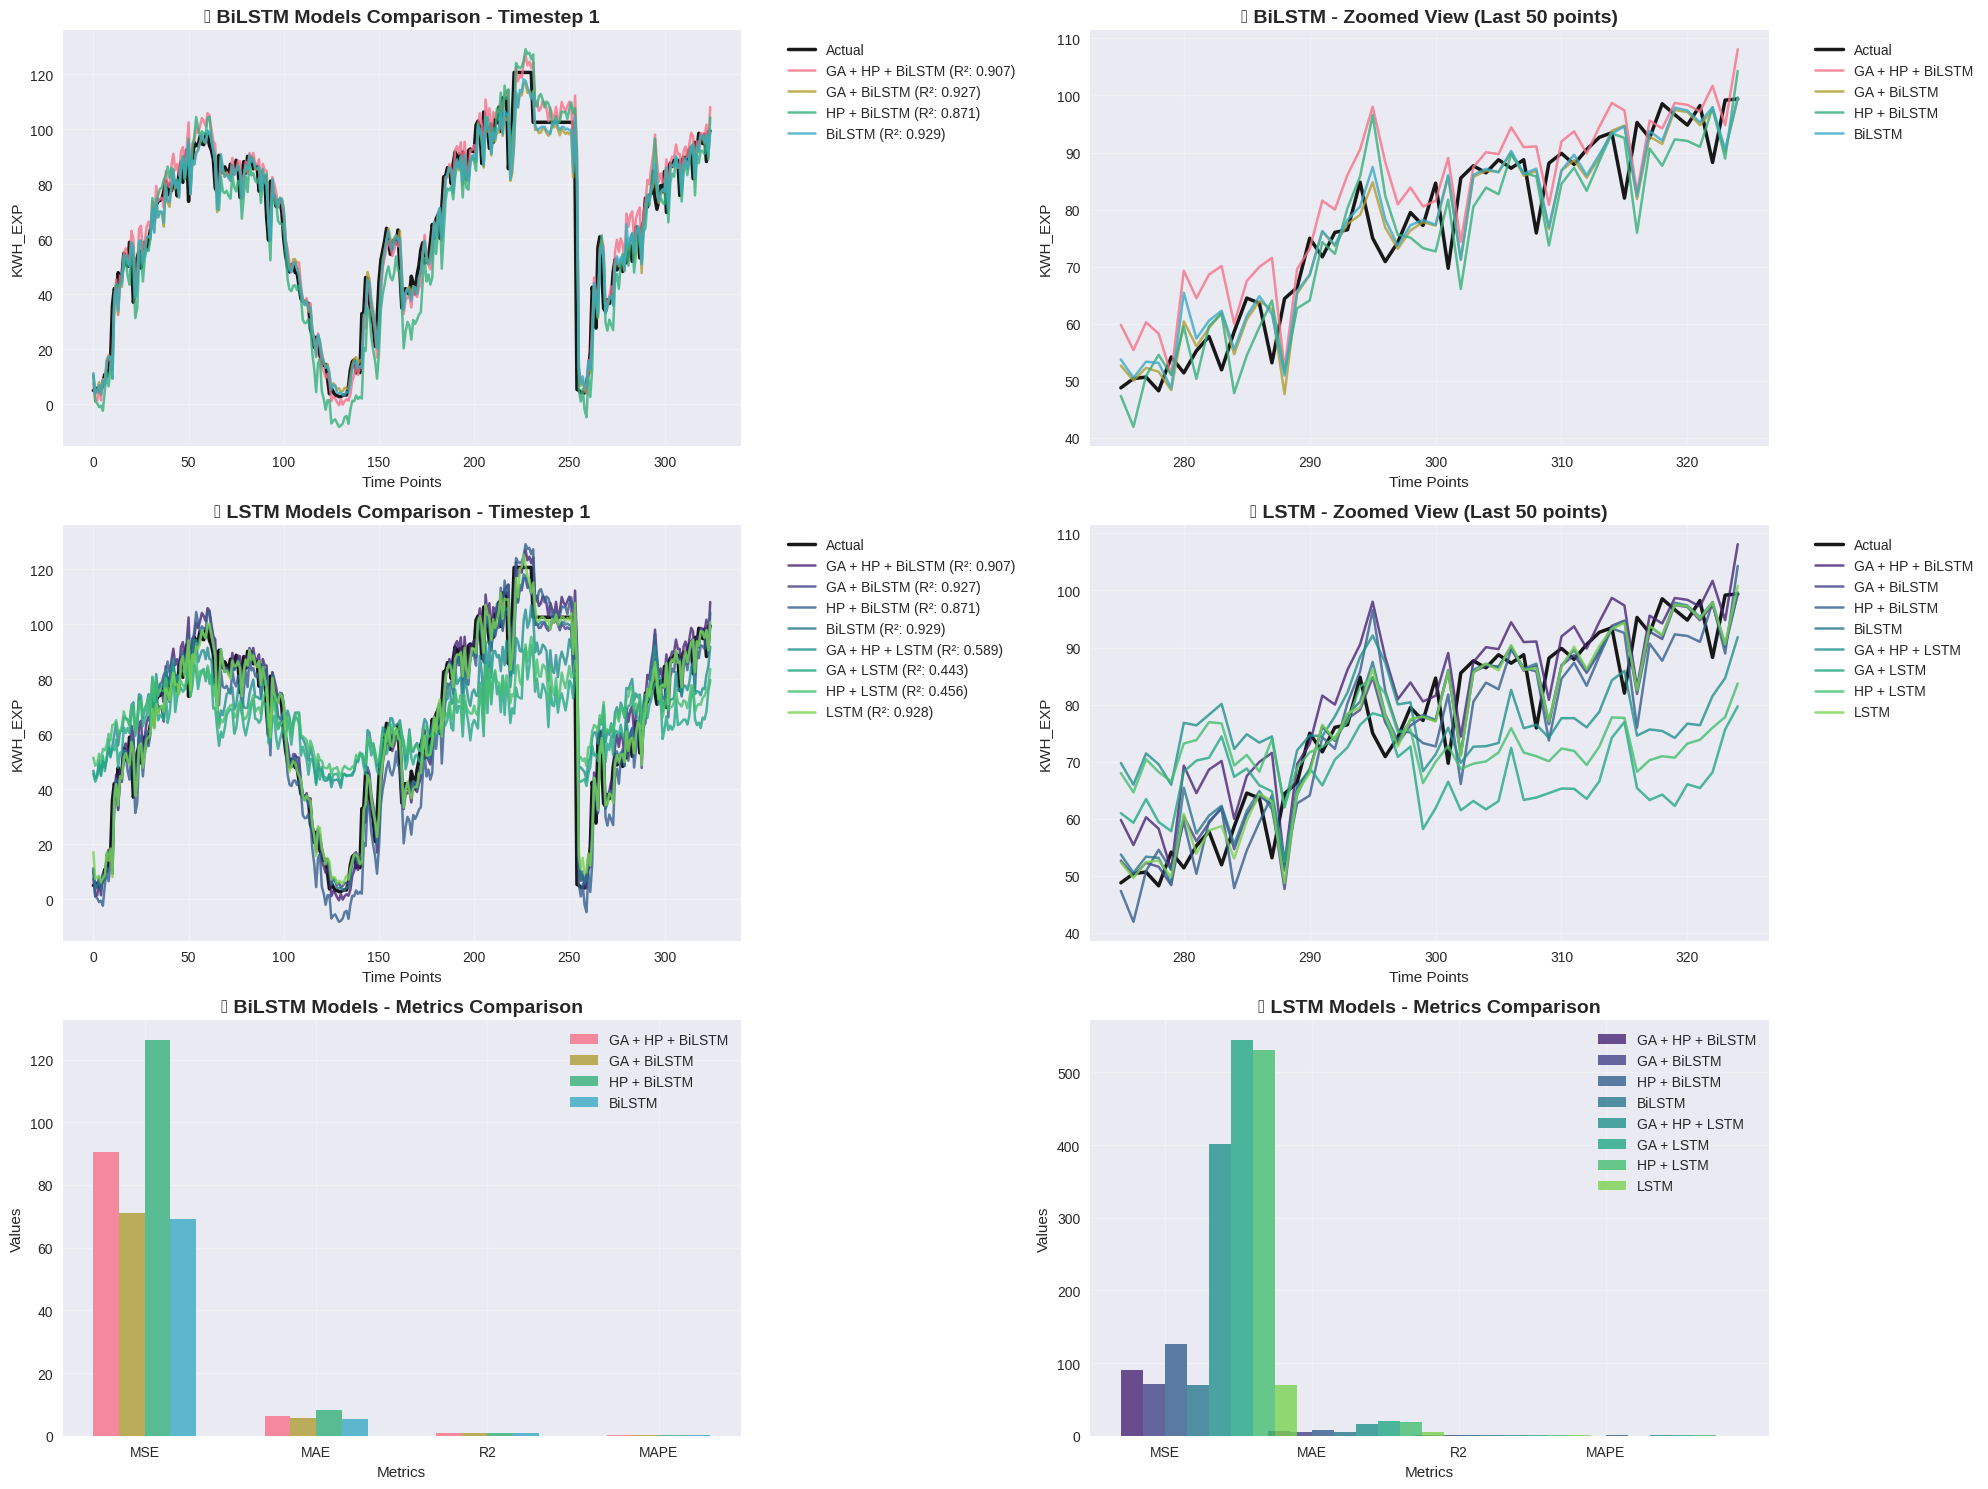


📋 DETAILED METRICS SUMMARY - TIMESTEP 1
Model                MSE          MAE          R²           MAPE         Type      
------------------------------------------------------------------------------------------------------------------------
GA + HP + BiLSTM     90.6068      6.3642       0.9073       0.2041       BiLSTM    
GA + BiLSTM          71.1729      5.5887       0.9272       0.1797       BiLSTM    
HP + BiLSTM          126.2184     8.2360       0.8708       0.3251       BiLSTM    
BiLSTM               69.2341      5.4578       0.9291       0.1729       BiLSTM    

GA + HP + BiLSTM     90.6068      6.3642       0.9073       0.2041       LSTM      
GA + BiLSTM          71.1729      5.5887       0.9272       0.1797       LSTM      
HP + BiLSTM          126.2184     8.2360       0.8708       0.3251       LSTM      
BiLSTM               69.2341      5.4578       0.9291       0.1729       LSTM      
GA + HP + LSTM       401.9827     16.1824      0.5886       1.0517       LSTM    

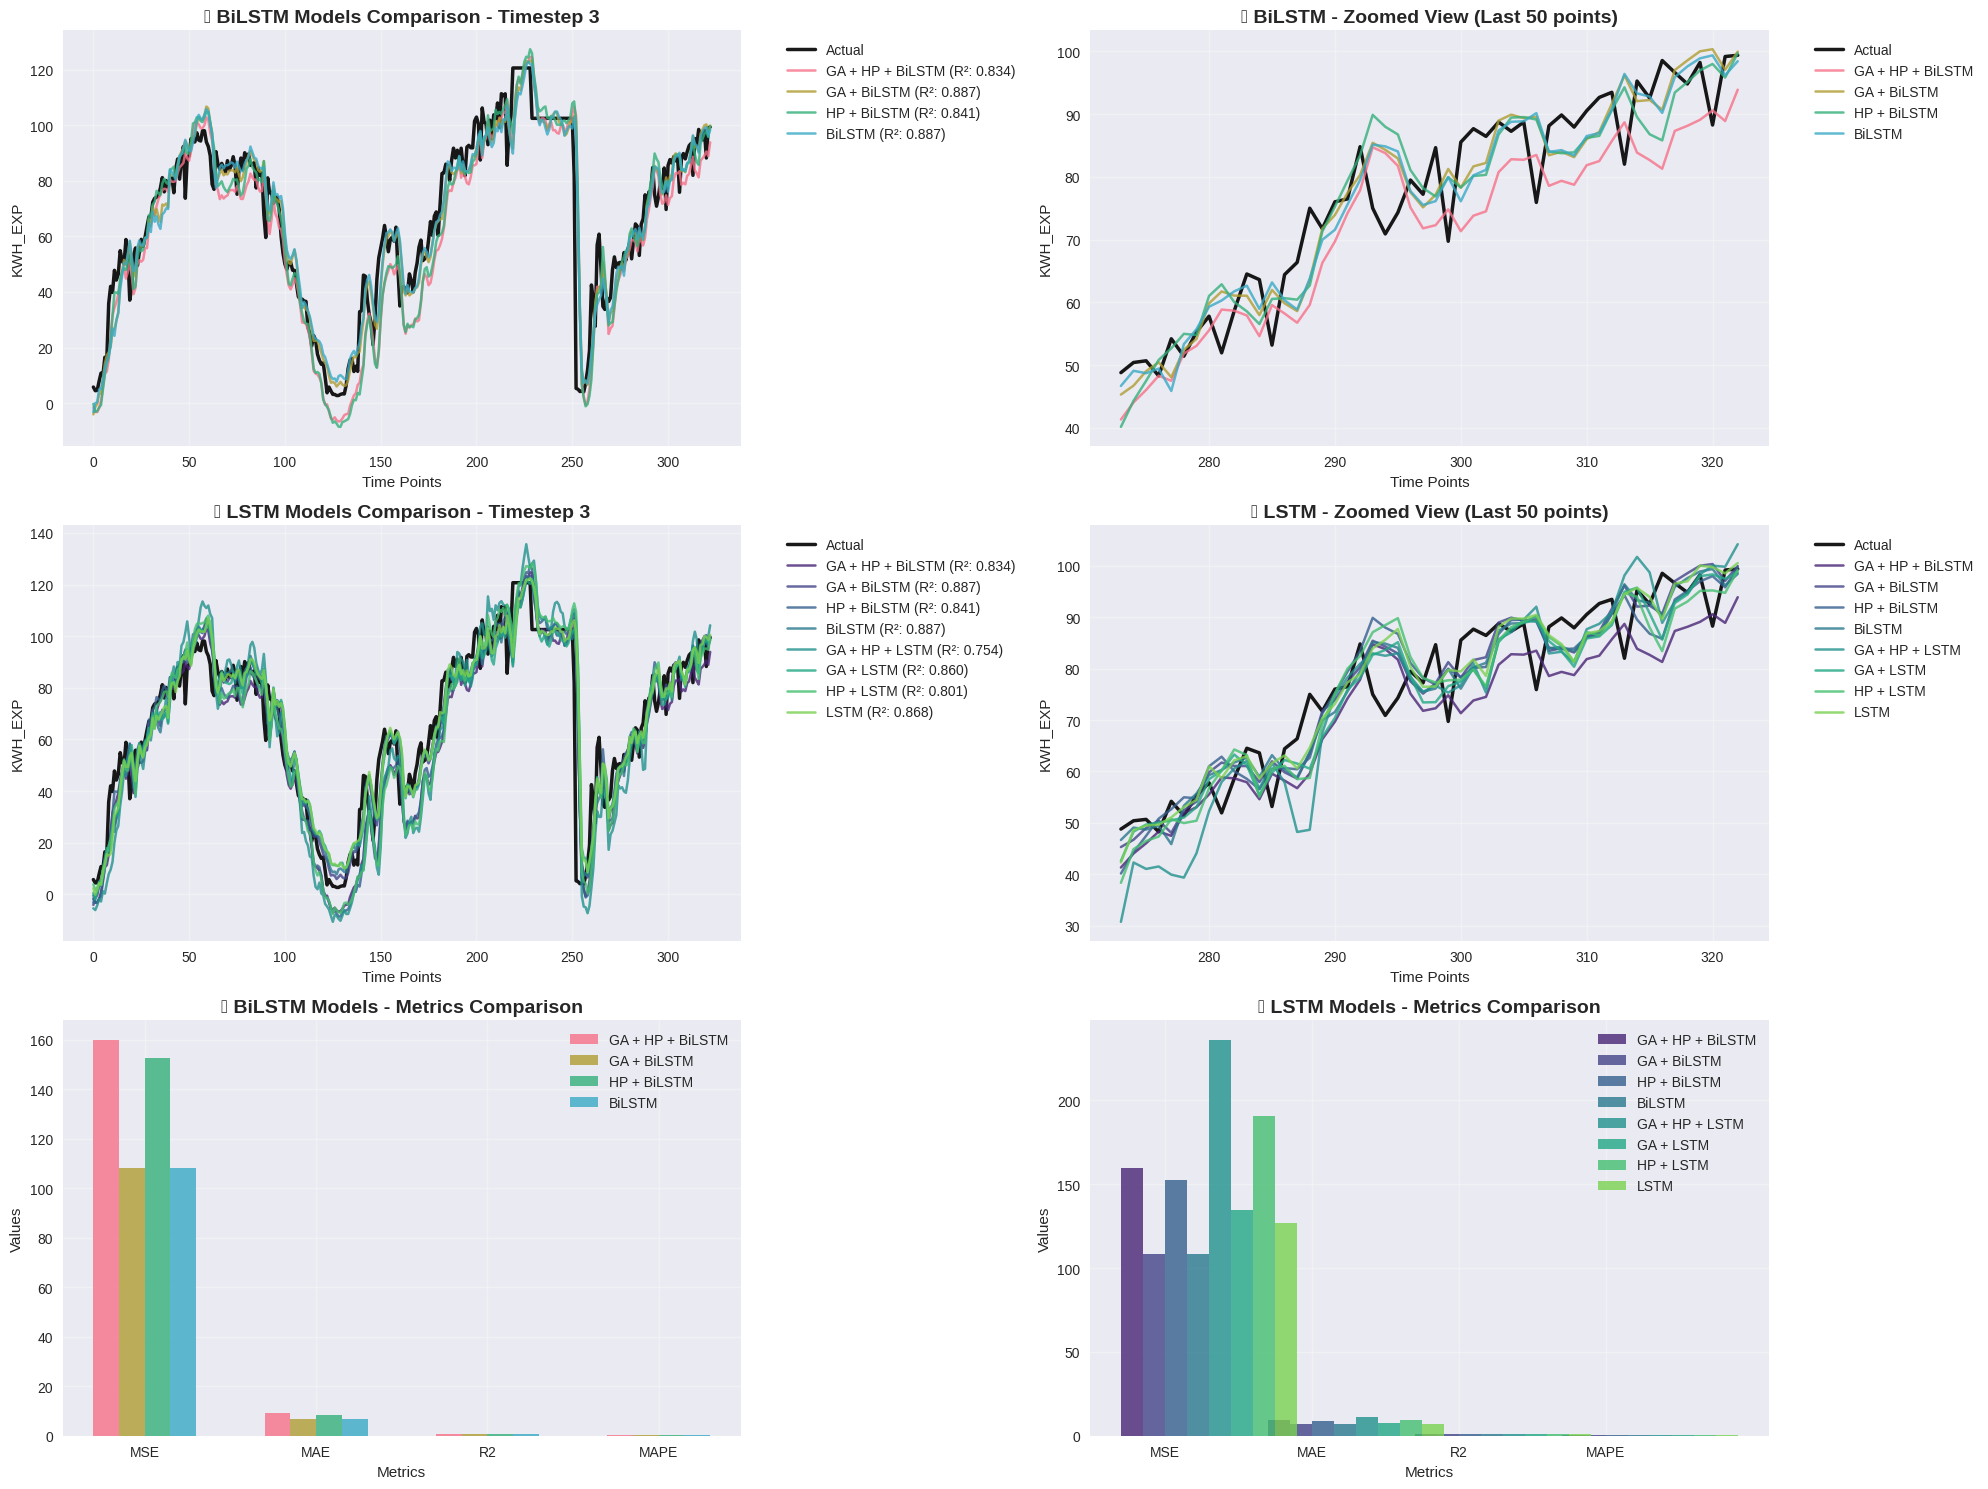


📋 DETAILED METRICS SUMMARY - TIMESTEP 3
Model                MSE          MAE          R²           MAPE         Type      
------------------------------------------------------------------------------------------------------------------------
GA + HP + BiLSTM     159.8094     9.2167       0.8335       0.3898       BiLSTM    
GA + BiLSTM          108.2709     6.7795       0.8872       0.2873       BiLSTM    
HP + BiLSTM          152.5056     8.5362       0.8411       0.3960       BiLSTM    
BiLSTM               108.1396     6.9120       0.8873       0.3024       BiLSTM    

GA + HP + BiLSTM     159.8094     9.2167       0.8335       0.3898       LSTM      
GA + BiLSTM          108.2709     6.7795       0.8872       0.2873       LSTM      
HP + BiLSTM          152.5056     8.5362       0.8411       0.3960       LSTM      
BiLSTM               108.1396     6.9120       0.8873       0.3024       LSTM      
GA + HP + LSTM       235.8745     11.2351      0.7543       0.5005       LSTM    

In [ ]:
# 🚀 EXECUTE THE COMPREHENSIVE ANALYSIS
# Uncomment the line below to run the analysis

# For full analysis with Genetic Algorithm (slower but more comprehensive)
run_complete_analysis([1, 3, 7], use_genetic_algorithm=True)

# For faster analysis without GA
# run_complete_analysis([1, 3, 7], use_genetic_algorithm=False)
